In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import linear_like, quad_like, log_like
linear, quad, log = linear_like(), quad_like(), log_like()

- Additional Bayesian term recovers correct parameters

- Same as least squares 

### Try on simple functions

In [2]:
def compare_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X, repeats=10):
    repeats = 10
    bs = np.zeros(repeats)
    ls = np.zeros(repeats)
    for i in range(repeats):
        Xs = generate_Xs(nk)
        y = likelihood.func(Xs, theta_true)
        bs[i] = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
        ls[i] = minimise_ls(y, likelihood, mean_X, theta_true).x
    print(f"Bayes: {bs.mean(axis=0):.3f} +/- {bs.std(axis=0):.3f}")
    print(f"LS: {ls.mean(axis=0):.3f} +/- {ls.std(axis=0):.3f}")

def plot_bayes_ls(nk, theta_true, likelihood, mean_X, covinv_X):
    Xs = generate_Xs(nk)
    y = likelihood.func(Xs, theta_true)

    theta_bayes = minimise_bayes(y, likelihood, mean_X, covinv_X, theta_true).x
    theta_ls, = minimise_ls(y, likelihood, mean_X, 10).x

    plt.plot(Xs, y, 'x', ms=2)
    plt.plot(Xs, likelihood.func(Xs, theta_bayes), label='bayes')
    plt.plot(Xs, likelihood.func(Xs, theta_ls), label='ls')
    plt.legend();
    print(f'bayes: {theta_bayes}')
    print(f'ls: {theta_ls}')

In [4]:
nk = data_at_iteration(samples_g_1, 500)[0]
# nk = 500 * np.ones(500)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

### Linear

In [5]:
compare_bayes_ls(nk, 10, linear, mean_X, covinv_X)

Bayes: 10.007 +/- 0.016
LS: 10.132 +/- 0.156


bayes: [10.01414095]
ls: 9.924426798560681


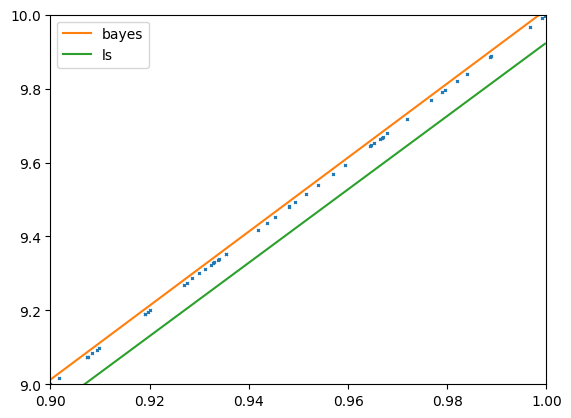

In [6]:
plot_bayes_ls(nk, 10, linear, mean_X, covinv_X)
plt.xlim(0.9, 1.0)
plt.ylim(9, 10);

gaussian: [10.05026551]
bayes: [10.01039105]


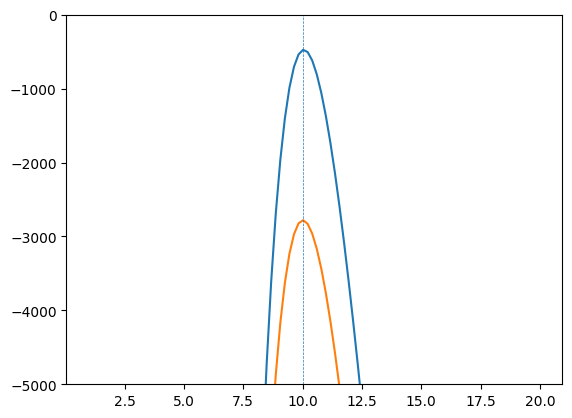

In [9]:
dtrue = 10
Xs = generate_Xs(nk)
y = linear.func(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, linear, mean_X, covinv_X, d)
plt.plot(ds, logprs_gaussian)
print(f'gaussian: {minimise_gaussian(y, linear, mean_X, covinv_X, 10).x}')

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, linear, mean_X, covinv_X, d)
plt.plot(ds, logprs_bayes)
print(f'bayes: {minimise_bayes(y, linear, mean_X, covinv_X, 10).x}')
plt.axvline(x=10, ls='--', lw=.5)
plt.ylim(-5000, 0);

### Quadratic

In [10]:
compare_bayes_ls(nk, 10, quad, mean_X, covinv_X)

Bayes: 10.021 +/- 0.023
LS: 9.876 +/- 0.272


bayes: [9.99767736]
ls: 9.572262408128362


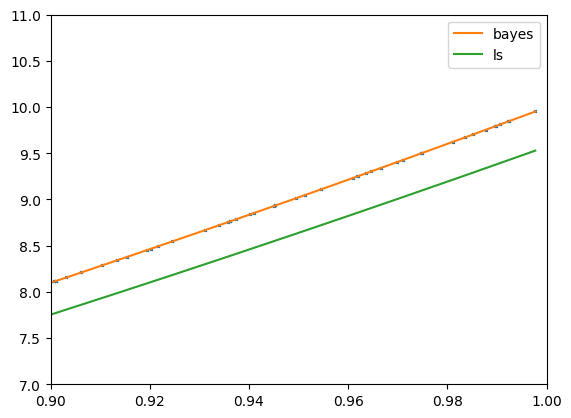

In [12]:
plot_bayes_ls(nk, 10, quad, mean_X, covinv_X)
plt.xlim(0.9, 1.0)
plt.ylim(7, 11);

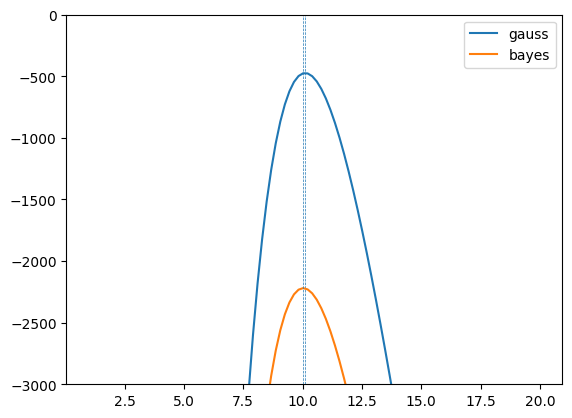

In [13]:
dtrue = 10
Xs = generate_Xs(nk)
y = quad.func(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, quad, mean_X, covinv_X, d)
d_gauss = minimise_gaussian(y, quad, mean_X, covinv_X, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, quad, mean_X, covinv_X, d)
d_bayes = minimise_bayes(y, quad, mean_X, covinv_X, 10).x

plt.plot(ds, logprs_gaussian, label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, logprs_bayes, label='bayes')
plt.axvline(x=d_bayes, ls='--', lw=.5)
plt.ylim(-3000, 0);
plt.legend();

### Log

In [14]:
compare_bayes_ls(nk, 10, log, mean_X, covinv_X)

Bayes: 10.097 +/- 0.280
LS: 10.062 +/- 0.249


bayes: [10.38350258]
ls: 10.191797388718626


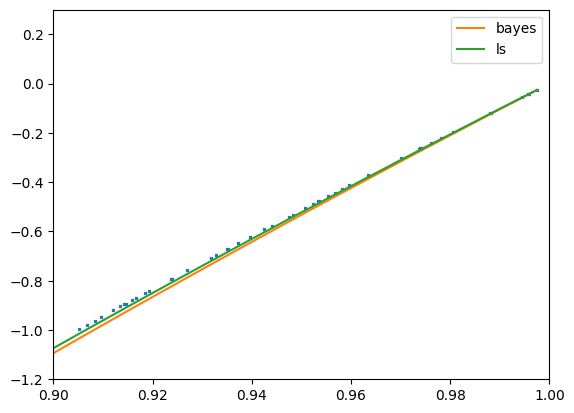

In [15]:
plot_bayes_ls(nk, 10, log, mean_X, covinv_X)
plt.xlim(0.9, 1)
plt.ylim(-1.2, 0.3);

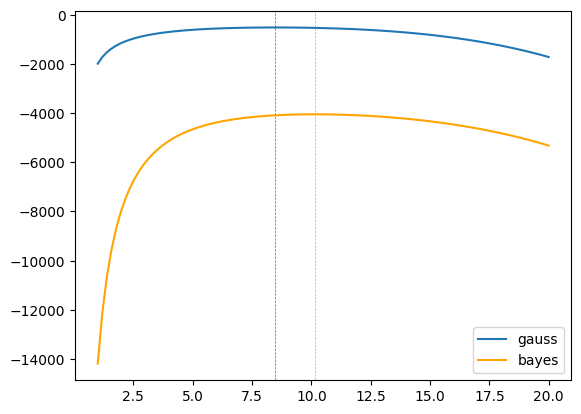

In [15]:
dtrue = 10
Xs = generate_Xs(nk)
y = log(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, log_inverse, mean_X, covinv_X, d)
d_gauss = minimise_gaussian(y, log_inverse, mean_X, covinv_X, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, log_inverse, log_prime, mean_X, covinv_X, d)
d_bayes = minimise_bayes(y, log_inverse, log_prime, mean_X, covinv_X, 10).x

plt.plot(ds, logprs_gaussian, label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, logprs_bayes, label='bayes', color='orange')
plt.axvline(x=d_bayes, ls='--', lw=.5, color='orange')
plt.legend();